In [ ]:
######################
# Jason Hemedinger
# Argonne National Laboratory
# This notebook will pull radar data from Amazon S3

In [1]:
import pyart, boto3, tempfile, os, shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from tint import Cell_tracks
from tint import animate as tint_animate
from tint.visualization import embed_mp4_as_gif
from glob import glob
from datetime import datetime


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def get_current_scan(station, key_index):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier, must be entered using quote marks
              Example: 'KEPZ'
            
    key_index = Number of keys you want pulled. 
                If a positive number then the number of keys pulled will start from the first key of the day.
                If a negative number then the number of keys pulled will count backwards from most recent key.
                Example: 15 would pull the first 15 keys for the day, while -15 would
                pull the 15 most recent keys
    '''
    #creating a bucket and a client to be able to pull data from AWS and settin 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting the date and time to current.
    #this will allow for allow the current date's radar scands to be pulled
    desired_datetime = datetime.utcnow()
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+station)
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    print(my_list_of_keys[key_index:])
    
    return aws_radar, keys

In [3]:
#setting the radar site and which keys to pull.
aws_radar, keys = get_current_scan('KLOT', key_index=-10)

['2018/06/08/KLOT/KLOT20180608_150404_V06', '2018/06/08/KLOT/KLOT20180608_150826_V06', '2018/06/08/KLOT/KLOT20180608_151248_V06', '2018/06/08/KLOT/KLOT20180608_151711_V06', '2018/06/08/KLOT/KLOT20180608_152133_V06', '2018/06/08/KLOT/KLOT20180608_152555_V06', '2018/06/08/KLOT/KLOT20180608_153017_V06', '2018/06/08/KLOT/KLOT20180608_153440_V06', '2018/06/08/KLOT/KLOT20180608_153902_V06', '2018/06/08/KLOT/KLOT20180608_154324_V06']


In [4]:
#setting the display extent for KLOT
max_lon = -87
min_lon = -90
max_lat = 43
min_lat = 41
lat_lines = np.arange(min_lat, max_lat, .2)
lon_lines = np.arange(min_lon, max_lon, .5)

#animating using matplotlib and pyart
def animate(nframe):
    plt.clf()
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(keys[nframe], localfile.name)
    radar = pyart.io.read(localfile.name)
    display = pyart.graph.RadarMapDisplay(radar)
    # Delete radar after use to save memory.
    del radar
    display.plot_ppi_map('reflectivity', sweep=0, resolution='l',
                         vmin=-8, vmax=64, mask_outside=False,
                         min_lat=min_lat,
                         max_lat=max_lat, min_lon=min_lon, max_lon=max_lon,
                         lat_lines=lat_lines, lon_lines=lon_lines)
    display.basemap.drawcounties()
    display.plot_point(-87.981810, 41.713969 , label_text='ANL', color='k')
fig = plt.figure(figsize=(10, 8))
anim_klot = animation.FuncAnimation(fig, animate,
                                    frames=len(keys))
anim_klot.save('reflectivity_animation.gif',
               writer='imagemagick', fps=2)
plt.close()

In [5]:
#turing the data into grid data and saving it to a folder
def get_grid(aws_radar, key):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(key, localfile.name)
    radar = pyart.io.read(localfile.name)
    grid = pyart.map.grid_from_radars(
            radar, grid_shape=(31, 401, 401),
            grid_limits=((0, 15000), (-200000, 200000), (-200000, 200000)),
            fields=['reflectivity'], gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=200.)
    return grid


out_dir = '/home/jhemedinger/suli_projects/chicago-nowcast/data'
for num, key in enumerate(keys):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join(out_dir, 'grid_' + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid

saving grid 0
saving grid 1
saving grid 2
saving grid 3
saving grid 4
saving grid 5
saving grid 6
saving grid 7
saving grid 8
saving grid 9


In [6]:
#files_2 = [os.path.join(out_dir, fn) for fn in os.listdir(out_dir)]
files = glob(out_dir + '/grid_*')

In [7]:
grid_gen = (pyart.io.read_grid(f) for f in files)
#grid_list = [pyart.io.read_grid(f) for f in files]

In [8]:
tracks_obj = Cell_tracks()
tracks_obj.get_tracks(grid_gen)

Writing tracks for scan 0
Writing tracks for scan 1
Writing tracks for scan 2
Writing tracks for scan 3
Writing tracks for scan 4
Writing tracks for scan 5
Writing tracks for scan 6
Writing tracks for scan 7
Writing tracks for scan 8
Writing tracks for scan 9


time elapsed 0.2 minutes


In [9]:
tracks_obj.tracks

time   grid_x   grid_y      lon      lat    area  \
scan uid                                                                   
0    0   2018-06-08 15:21:33   34.000   90.000 -90.0507  40.5983    15.0   
     1   2018-06-08 15:21:33   20.959  131.004 -90.2164  40.9641  1329.0   
     2   2018-06-08 15:21:33  117.708  106.000 -89.0579  40.7549    24.0   
     3   2018-06-08 15:21:33  118.818  113.242 -89.0470  40.8180    33.0   
     4   2018-06-08 15:21:33  399.364  123.909 -85.7166  40.8965    11.0   
     5   2018-06-08 15:21:33  139.125  127.600 -88.8108  40.9546    40.0   
     6   2018-06-08 15:21:33   98.083  190.606 -89.3096  41.5170  7686.0   
     7   2018-06-08 15:21:33   49.250  134.375 -89.8838  40.9968     8.0   
     8   2018-06-08 15:21:33   44.833  144.259 -89.9340  41.0859    54.0   
     9   2018-06-08 15:21:33  330.567  155.466 -86.5189  41.1891  1319.0   
     10  2018-06-08 15:21:33  375.009  155.128 -85.9932  41.1807   109.0   
     11  2018-06-08 15:21:33  396.053  159.737 -85.7407  41.2208    95.0   
     12  2018-06-08 15:21:33   47.481  160.963 -89.9144  41.2392    54.0   
     13  2018-06-08 15:21:33   35.154  159.308 -90.0573  41.2188    26.0   
     14  2018-06-08 15:21:33  312.534  164.914 -86.7321  41.2817    58.0   
     15  2018-06-08 15:21:33  291.222  167.722 -86.9949  41.3115    18.0   
     16  2018-06-08 15:21:33  282.700  169.600 -87.0904  41.3304    10.0   
     17  2018-06-08 15:21:33  255.949  184.246 -87.4124  41.4586   195.0   
     18  2018-06-08 15:21:33  297.091  176.364 -86.9218  41.3827    11.0   
     19  2018-06-08 15:21:33  259.683  214.535 -87.3613  41.7371  1494.0   
     20  2018-06-08 15:21:33  355.577  184.549 -86.2124  41.4543    71.0   
     21  2018-06-08 15:21:33  320.818  186.318 -86.6321  41.4694    44.0   
     22  2018-06-08 15:21:33   32.000  191.750 -90.1024  41.5148     8.0   
     23  2018-06-08 15:21:33  189.824  193.941 -88.2046  41.5504    17.0   
     24  2018-06-08 15:21:33  262.000  192.400 -87.3396  41.5301    10.0   
     25  2018-06-08 15:21:33  169.917  194.833 -88.4450  41.5589    12.0   
     26  2018-06-08 15:21:33  163.267  200.333 -88.5294  41.6036    15.0   
     27  2018-06-08 15:21:33  296.909  201.364 -86.9177  41.6075    11.0   
     28  2018-06-08 15:21:33  166.364  204.455 -88.4936  41.6397    11.0   
     29  2018-06-08 15:21:33  183.615  204.462 -88.2770  41.6403    13.0   
...                      ...      ...      ...      ...      ...     ...   
9    332 2018-06-08 15:30:17  242.647  242.529 -87.5642  41.9900    17.0   
     445 2018-06-08 15:30:17  154.769  244.538 -88.6291  42.0079    13.0   
     446 2018-06-08 15:30:17    3.750  247.250 -90.4567  42.0028    12.0   
     406 2018-06-08 15:30:17  243.888  252.500 -87.5514  42.0709    98.0   
     447 2018-06-08 15:30:17  226.923  255.077 -87.7572  42.0986    13.0   
     448 2018-06-08 15:30:17  234.188  257.562 -87.6722  42.1253    16.0   
     372 2018-06-08 15:30:17    9.741  259.556 -90.3884  42.1211    27.0   
     449 2018-06-08 15:30:17   18.618  259.382 -90.2790  42.1143    34.0   
     375 2018-06-08 15:30:17  138.143  262.286 -88.8366  42.1596    63.0   
     374 2018-06-08 15:30:17  133.162  268.430 -88.8980  42.2131   142.0   
     450 2018-06-08 15:30:17  120.500  264.500 -89.0553  42.1759    10.0   
     380 2018-06-08 15:30:17  200.688  268.688 -88.0723  42.2250    16.0   
     379 2018-06-08 15:30:17   83.914  280.938 -89.4955  42.3243   128.0   
     333 2018-06-08 15:30:17  191.048  276.286 -88.1939  42.2879    21.0   
     451 2018-06-08 15:30:17  155.861  277.778 -88.6195  42.3047    36.0   
     384 2018-06-08 15:30:17  169.500  278.100 -88.4492  42.3053    30.0   
     383 2018-06-08 15:30:17  143.493  283.110 -88.7780  42.3488    73.0   
     452 2018-06-08 15:30:17  196.700  280.200 -88.1209  42.3239    10.0   
     257 2018-06-08 15:30:17   54.406  319.945 -89.8702  42.6699  2036.0   
     453 2018-06-08 15:30:17  155.556  283.333 -88.6199  42.3496     9.0

In [10]:
from tint.visualization import embed_mp4_as_gif
if os.path.exists(out_dir + '/test_animation.mp4'):
    print(out_dir + '/test_animation.mp4'
          + ' already exists, removing file')
    os.remove(out_dir + '/test_animation.mp4')

/home/jhemedinger/suli_projects/chicago-nowcast/data/test_animation.mp4 already exists, removing file


In [11]:
grid_gen = (pyart.io.read_grid(f) for f in files)
tint_animate(tracks_obj, grid_gen, os.path.join(out_dir, 'test_animation'))

foobar
Animating 10 frames
Frame: 0
reflectivity 3
-8 64
Frame: 1
reflectivity 3
-8 64
Frame: 2
reflectivity 3
-8 64
Frame: 3
reflectivity 3
-8 64
Frame: 4
reflectivity 3
-8 64
Frame: 5
reflectivity 3
-8 64
Frame: 6
reflectivity 3
-8 64
Frame: 7
reflectivity 3
-8 64
Frame: 8
reflectivity 3
-8 64
Frame: 9
reflectivity 3
-8 64


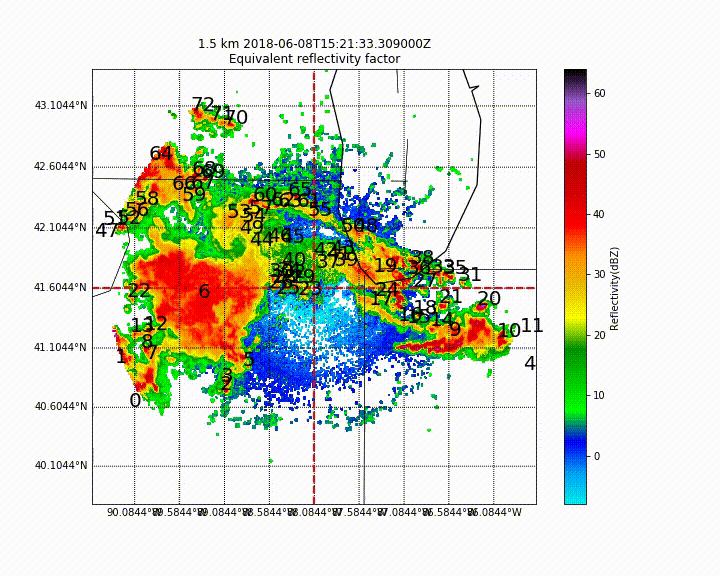

In [12]:
embed_mp4_as_gif(out_dir + '/test_animation.mp4')